# Experiments: model training curves and evaluations

In this notebook, we will present some trained models and explain the results.

In [14]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

from corridor_starter import play_game
from corridor import Corridor
from models import QlearningAgent, SarsaAgent, GreedyPathAgent, RandomAgent, DQNAgent

BASE = Path('saved_models')
json_files = sorted([p for p in BASE.glob('*.json')])
json_files

[PosixPath('saved_models/DQNAgent_B5_E2000_VSCurriculumMixed.json'),
 PosixPath('saved_models/DQNAgent_B5_E2000_VSRandomToGreedy.json'),
 PosixPath('saved_models/DQNAgent_B5_E5000_VSCurriculumMixed.json'),
 PosixPath('saved_models/DQNAgent_B5_E5000_VSRandomOnly.json'),
 PosixPath('saved_models/DQNAgent_B9_E5000_VSCurriculumMixed.json'),
 PosixPath('saved_models/QAgent_B5_E2000_VSCurriculumMixed.json'),
 PosixPath('saved_models/QAgent_B5_E5000_VSCurriculumMixed.json'),
 PosixPath('saved_models/QAgent_B5_E5000_VSRandomOnly.json'),
 PosixPath('saved_models/QAgent_B5_E5000_VSRandomToGreedy.json'),
 PosixPath('saved_models/SarsaAgent_B5_E2000_VSCurriculumMixed.json'),
 PosixPath('saved_models/SarsaAgent_B5_E5000_VSCurriculumMixed.json'),
 PosixPath('saved_models/SarsaAgent_B5_E5000_VSRandomOnly.json'),
 PosixPath('saved_models/SarsaAgent_B5_E5000_VSRandomToGreedy.json')]

In [15]:
def find_weight_for(json_path: Path):
    base = json_path.stem
    candidates = []
    for ext in ['.pkl', '.pth']:
        p = json_path.with_suffix(ext)
        if p.exists():
            candidates.append(p)
    return candidates[0] if candidates else None

def agent_class_for(name: str):
    if 'QAgent' in name or name.startswith('QAgent') or name.startswith('QAgent'):
        return QlearningAgent
    if 'Sarsa' in name or name.startswith('Sarsa'):
        return SarsaAgent
    if 'DQNAgent' in name or name.startswith('DQNAgent') or 'DQN' in name:
        return DQNAgent
    # Fallback: greedy/random (not training logs typically)
    if 'Greedy' in name:
        return GreedyPathAgent
    if 'Random' in name:
        return RandomAgent
    return None

models_info = []
for j in json_files:
    w = find_weight_for(j)
    cls = agent_class_for(j.stem)
    models_info.append({'json': j, 'weights': w, 'class': cls, 'name': j.stem})

models_info

[{'json': PosixPath('saved_models/DQNAgent_B5_E2000_VSCurriculumMixed.json'),
  'weights': PosixPath('saved_models/DQNAgent_B5_E2000_VSCurriculumMixed.pth'),
  'class': models.dqn.dqn_agent.DQNAgent,
  'name': 'DQNAgent_B5_E2000_VSCurriculumMixed'},
 {'json': PosixPath('saved_models/DQNAgent_B5_E2000_VSRandomToGreedy.json'),
  'weights': PosixPath('saved_models/DQNAgent_B5_E2000_VSRandomToGreedy.pth'),
  'class': models.dqn.dqn_agent.DQNAgent,
  'name': 'DQNAgent_B5_E2000_VSRandomToGreedy'},
 {'json': PosixPath('saved_models/DQNAgent_B5_E5000_VSCurriculumMixed.json'),
  'weights': PosixPath('saved_models/DQNAgent_B5_E5000_VSCurriculumMixed.pth'),
  'class': models.dqn.dqn_agent.DQNAgent,
  'name': 'DQNAgent_B5_E5000_VSCurriculumMixed'},
 {'json': PosixPath('saved_models/DQNAgent_B5_E5000_VSRandomOnly.json'),
  'weights': PosixPath('saved_models/DQNAgent_B5_E5000_VSRandomOnly.pth'),
  'class': models.dqn.dqn_agent.DQNAgent,
  'name': 'DQNAgent_B5_E5000_VSRandomOnly'},
 {'json': PosixPat

In [21]:
# During the training phase, we saved all data into a JSON to draw graphs.
# We now load these JSON logs
logs = {}
for info in models_info:
    try:
        with open(info['json'], 'r') as f:
            data = json.load(f)
    except Exception as e:
        print('Could not load', info['json'], e)
        data = {}
    logs[info['name']] = data

{k: list(v.keys()) for k, v in list(logs.items())[:3]}

{'DQNAgent_B5_E2000_VSCurriculumMixed': ['rewards',
  'lengths',
  'win_rates',
  'eval_episodes',
  'epsilon'],
 'DQNAgent_B5_E2000_VSRandomToGreedy': ['rewards',
  'lengths',
  'win_rates',
  'eval_episodes',
  'epsilon'],
 'DQNAgent_B5_E5000_VSCurriculumMixed': ['rewards',
  'lengths',
  'win_rates',
  'eval_episodes',
  'epsilon']}

## Training curves

We'll plot the main `rewards` array from each JSON.

Note: The reward are not the same for the tabular Agents and DQN. Indeed in Tabular agents, we did a custom reward that attributes point based on a forward move (better), horinzontal move (not great), and backward move (bad). This strategies works really well but is quite costly in computation and since out DQN model is already slow due to the neural network, we removed it.
The point is that the ordinate axis reward value is lower for DQN because of the reward implementation, and not because of the performances of the model, as you'll be able to see next.

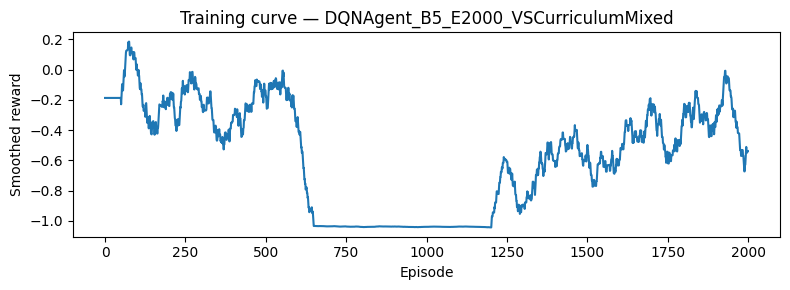

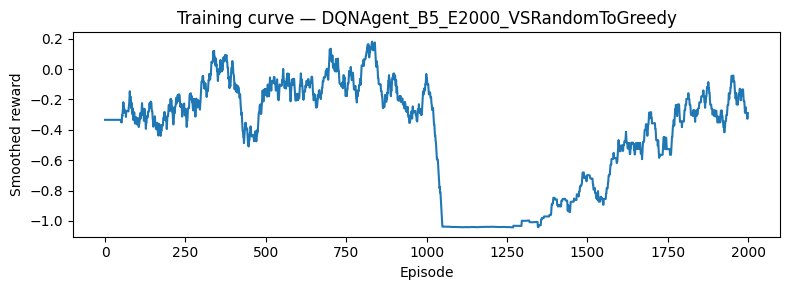

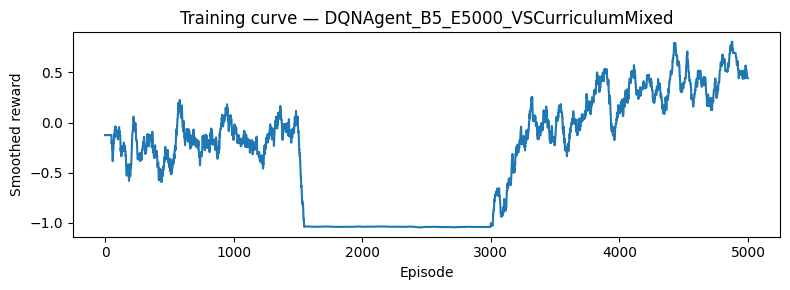

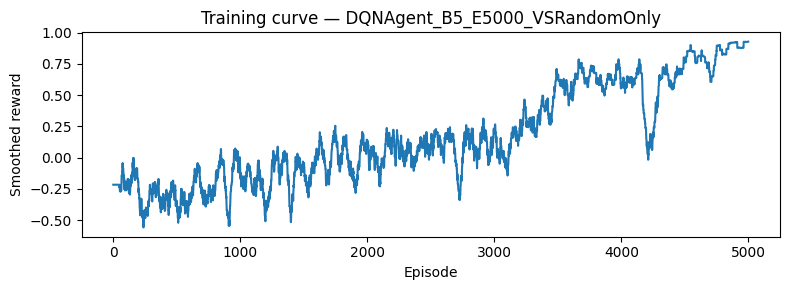

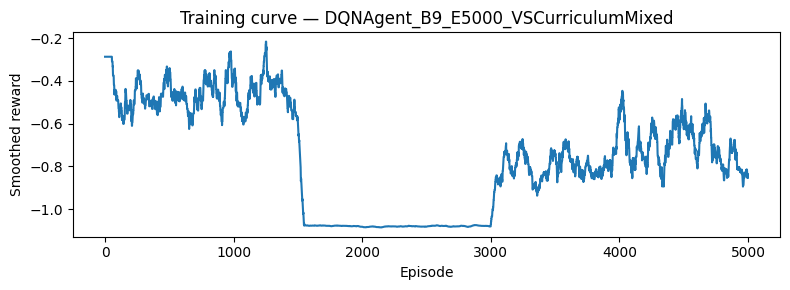

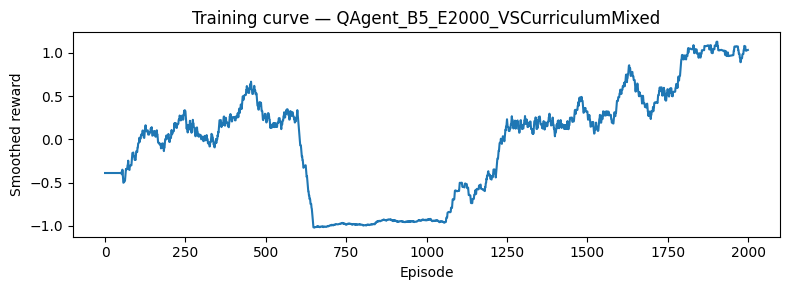

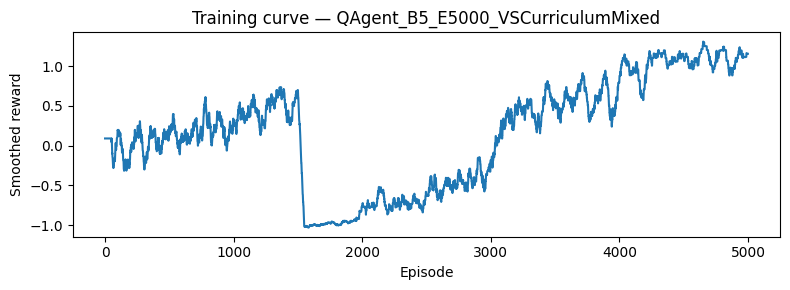

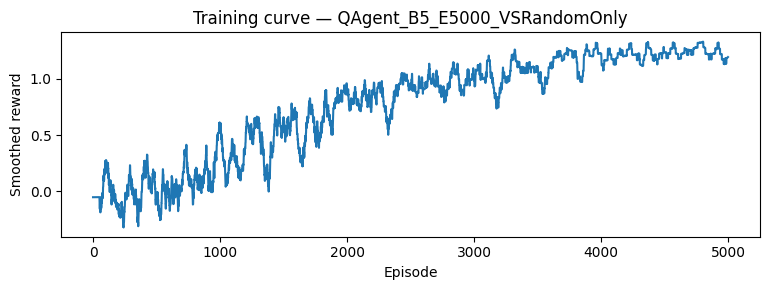

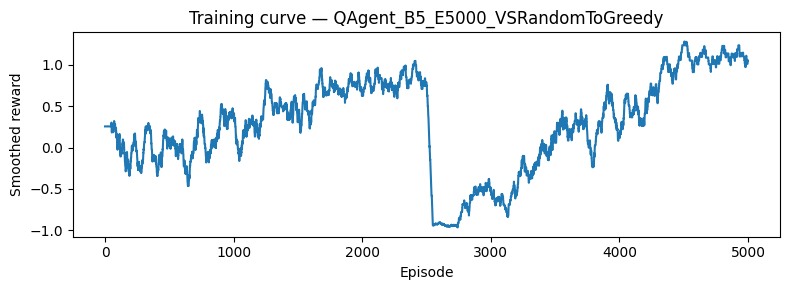

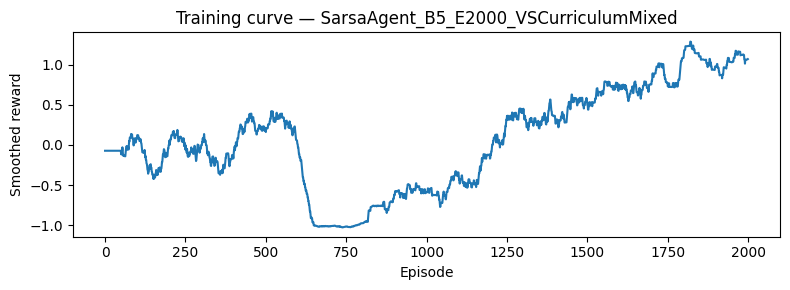

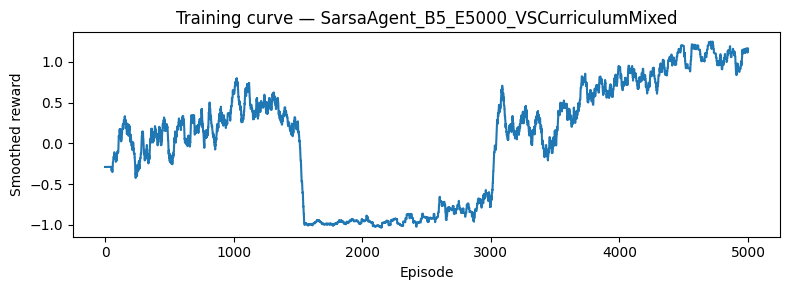

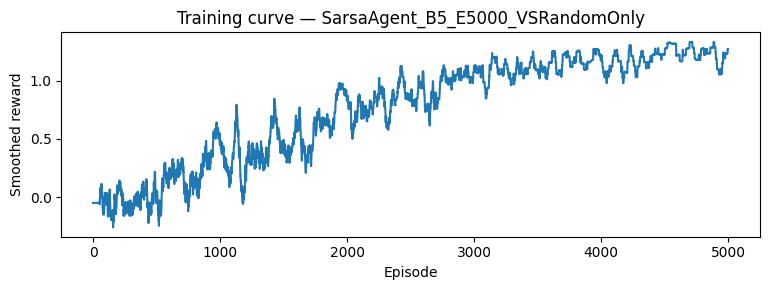

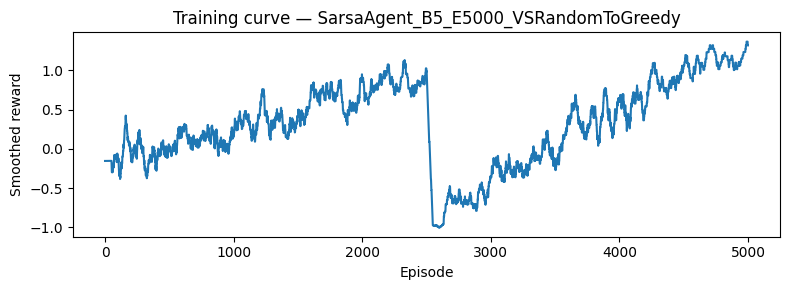

In [24]:
def smooth(x, w=50):
    # Made with AI to have readable curves
    if x is None or len(x)==0:
        return []
    w = max(1, w)
    cumsum = np.cumsum(np.insert(np.array(x), 0, 0))
    ma = (cumsum[w:] - cumsum[:-w]) / float(w)
    pad = [ma[0]]*(w-1) if len(ma)>0 else []
    return np.concatenate([pad, ma]) if len(ma)>0 else np.array([])

for name, data in logs.items():
    rewards = data.get('rewards') or data.get('episode_rewards') or data.get('train_rewards')
    if not rewards:
        print('No rewards series for', name)
        continue
    s = smooth(rewards, w=50)
    plt.figure(figsize=(8,3))
    plt.plot(s, color='tab:blue')
    plt.title(f'Training curve — {name}')
    plt.xlabel('Episode')
    plt.ylabel('Smoothed reward')
    plt.tight_layout()
    plt.show()

We have 3 kind of trainings:
- Only against Random
  - We see a clean curve going linearly upwards
- Against random and then against Greedy
  - When the opponent changes to Greedy, it goes straight down, which seems logical since the Greedy lets no room for failure and as such, tight room for quick improvement and adaptation. But still, it finally reaches a good end reward with enough episodes.
- Against Random then Greedy then a Mix of both (chosen randomly)
  - We see the same downfall when changing from Random to Greedy but when going into the Mix, it gets back to normal, the model learned to play against both models and seem to have a better understanding of it.

## Evaluate every model vs Random and Greedy
We use `play_game` from `corridor_starter`. For fairness we use the board size encoded in the filename (e.g. `B5`). Each evaluation runs a small number of games.

In [28]:
def extract_board_size(name):
    import re
    m = re.search(r'B(\d+)', name)
    return int(m.group(1)) if m else 9

def instantiate_agent(info):
    cls = info['class']
    if cls is None:
        return None
    bsize = extract_board_size(info['name'])
    load_path = str(info['weights']) if info['weights'] else None
    try:
        if cls is DQNAgent:
            return cls(name=info['name'], board_size=bsize, training_mode=False, load_path=load_path)
        else:
            return cls(name=info['name'], training_mode=False, load_path=load_path)
    except Exception as e:
        print('Could not instantiate', info['name'], e)
        return None

def evaluate_agent_vs_baseline(agent, baseline_cls, n_games=40, board_size=9):
    results = {'agent_win':0, 'baseline_win':0, 'draw':0}
    for g in range(n_games):
        env = Corridor(N=board_size, walls_per_player=10)
        baseline = baseline_cls(name='baseline', seed=100+g)
        # alternate who starts
        agent_first = (g % 2 == 0)
        if agent_first:
            out = play_game(env, agent, baseline, render=False)
            winner = out['winner']
            if winner is None:
                results['draw'] += 1
            elif winner == 1:
                results['agent_win'] += 1
            else:
                results['baseline_win'] += 1
        else:
            out = play_game(env, baseline, agent, render=False)
            winner = out['winner']
            if winner is None:
                results['draw'] += 1
            elif winner == 2:
                results['agent_win'] += 1
            else:
                results['baseline_win'] += 1
    return results

summary = {}
N_GAMES = 500
for info in models_info:
    print('Processing', info['name'])
    agent = instantiate_agent(info)
    if agent is None:
        print('Skipping', info['name'])
        continue
    bsize = extract_board_size(info['name'])
    res_rand = evaluate_agent_vs_baseline(agent, RandomAgent, n_games=N_GAMES, board_size=bsize)
    res_greed = evaluate_agent_vs_baseline(agent, GreedyPathAgent, n_games=N_GAMES, board_size=bsize)
    summary[info['name']] = {'random': res_rand, 'greedy': res_greed}

summary

Processing DQNAgent_B5_E2000_VSCurriculumMixed
DQN Agent using device: cuda
Approximation model loaded from saved_models/DQNAgent_B5_E2000_VSCurriculumMixed.pth
Processing DQNAgent_B5_E2000_VSRandomToGreedy
DQN Agent using device: cuda
Approximation model loaded from saved_models/DQNAgent_B5_E2000_VSRandomToGreedy.pth
Processing DQNAgent_B5_E5000_VSCurriculumMixed
DQN Agent using device: cuda
Approximation model loaded from saved_models/DQNAgent_B5_E5000_VSCurriculumMixed.pth
Processing DQNAgent_B5_E5000_VSRandomOnly
DQN Agent using device: cuda
Approximation model loaded from saved_models/DQNAgent_B5_E5000_VSRandomOnly.pth
Processing DQNAgent_B9_E5000_VSCurriculumMixed
DQN Agent using device: cuda
Approximation model loaded from saved_models/DQNAgent_B9_E5000_VSCurriculumMixed.pth
Processing QAgent_B5_E2000_VSCurriculumMixed
Processing QAgent_B5_E5000_VSCurriculumMixed
Processing QAgent_B5_E5000_VSRandomOnly
Processing QAgent_B5_E5000_VSRandomToGreedy
Processing SarsaAgent_B5_E2000_VS

{'DQNAgent_B5_E2000_VSCurriculumMixed': {'random': {'agent_win': 363,
   'baseline_win': 137,
   'draw': 0},
  'greedy': {'agent_win': 0, 'baseline_win': 500, 'draw': 0}},
 'DQNAgent_B5_E2000_VSRandomToGreedy': {'random': {'agent_win': 233,
   'baseline_win': 267,
   'draw': 0},
  'greedy': {'agent_win': 250, 'baseline_win': 250, 'draw': 0}},
 'DQNAgent_B5_E5000_VSCurriculumMixed': {'random': {'agent_win': 475,
   'baseline_win': 25,
   'draw': 0},
  'greedy': {'agent_win': 500, 'baseline_win': 0, 'draw': 0}},
 'DQNAgent_B5_E5000_VSRandomOnly': {'random': {'agent_win': 495,
   'baseline_win': 5,
   'draw': 0},
  'greedy': {'agent_win': 0, 'baseline_win': 500, 'draw': 0}},
 'DQNAgent_B9_E5000_VSCurriculumMixed': {'random': {'agent_win': 14,
   'baseline_win': 410,
   'draw': 76},
  'greedy': {'agent_win': 0, 'baseline_win': 500, 'draw': 0}},
 'QAgent_B5_E2000_VSCurriculumMixed': {'random': {'agent_win': 427,
   'baseline_win': 73,
   'draw': 0},
  'greedy': {'agent_win': 500, 'baseline_

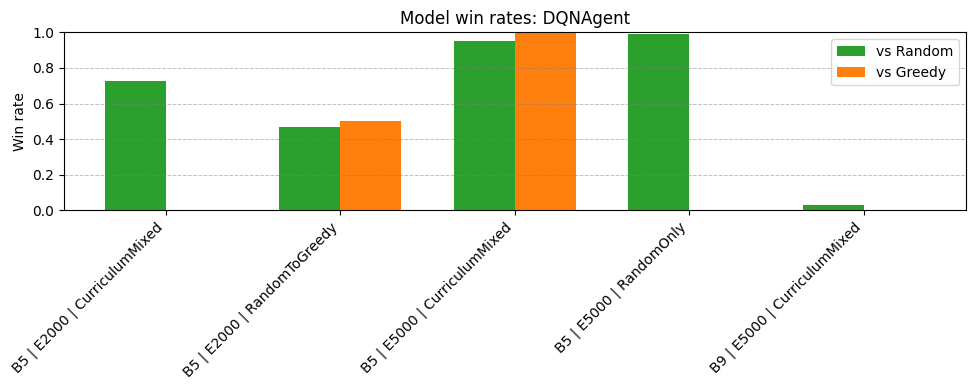

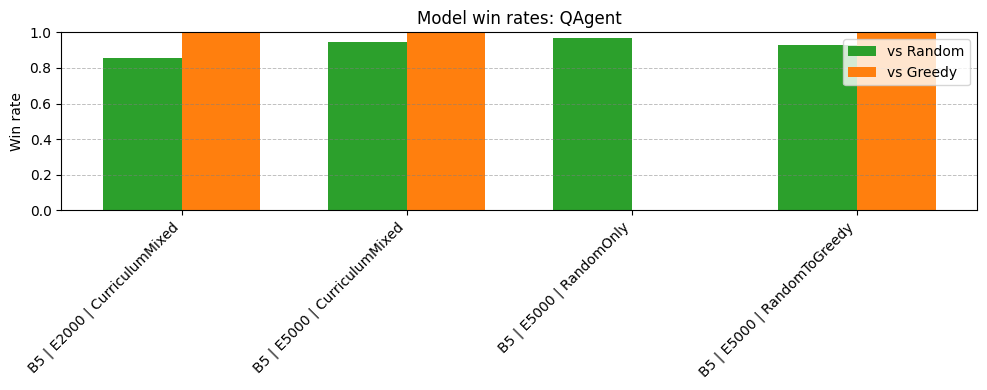

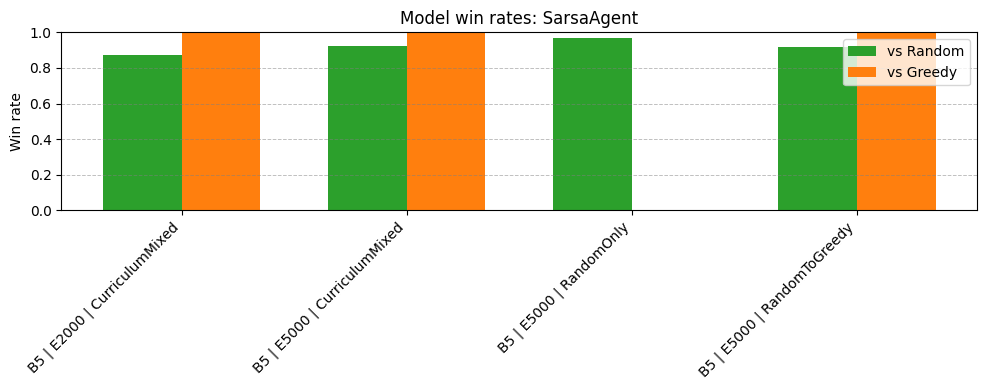

In [33]:
import re
from collections import defaultdict

def parse_model_name(name):
    m = re.match(r'([A-Za-z]+Agent)_B(\d+)_E(\d+)_VS(.+)', name)
    if m:
        agent, board, episodes, opponent = m.groups()
        return agent, int(board), int(episodes), opponent
    return name, '', '', ''

grouped = defaultdict(list)
for name in summary:
    agent, board, episodes, opponent = parse_model_name(name)
    grouped[agent].append((name, board, episodes, opponent))

for agent, models in grouped.items():
    names = []
    win_rand = []
    win_greed = []
    for name, board, episodes, opponent in models:
        vals = summary[name]
        rr = vals['random']
        gg = vals['greedy']
        label = f"B{board} | E{episodes} | {opponent}"
        names.append(label)
        win_rand.append(rr['agent_win'] / float(N_GAMES))
        win_greed.append(gg['agent_win'] / float(N_GAMES))

    x = np.arange(len(names))
    width = 0.35
    fig, ax = plt.subplots(figsize=(10,4))
    for pct in np.arange(0.2, 1.01, 0.2):
        ax.axhline(pct, color='gray', linestyle='--', linewidth=0.7, alpha=0.5)
    ax.bar(x - width/2, win_rand, width, label='vs Random', color='tab:green')
    ax.bar(x + width/2, win_greed, width, label='vs Greedy', color='tab:orange')
    ax.set_ylabel('Win rate')
    ax.set_title(f'Model win rates: {agent}')
    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=45, ha='right')
    ax.set_ylim(0,1)
    ax.legend()
    plt.tight_layout()
    plt.show()

DQN Analysis:
- We have low winrate on low number of episode and also on big board size
- We have low winrate on greedy when we only train on random (quite obvious)
- The Curriculum Mixed learning is quite effective, we have almost 100% win rate against both agents.

QAgent Analysis:
- We achieve a correct winrate even with low episode, but more episode is still more robust
- We have low winrate on greedy when we only train on random
- Curriculum learning with Mix at the end is a tiny bit better than training against Random and Greedy sequentially

Sarsa Analysis:
- We achieve a correct winrate even with low episode, but more episode is still more robust
- We have low winrate on greedy when we only train on random
- Curriculum learning with Mix at the end is a tiny bit better than training against Random and Greedy sequentially

## Agent vs Agent: Model Battles

We now evaluate direct confrontations between different pre-trained agents. This allows us to compare the learning strategies and robustness of each approach in a competitive setting, beyond just their performance against Random or Greedy baselines.

For each matchup, we will run a series of games with alternating starting positions and report the win rates.

In [48]:
# Define the matchups
agent_pairs = [
    # Same model, only random train vs curriculum train
    ("DQNAgent_B5_E5000_VSRandomOnly", "DQNAgent_B5_E5000_VSCurriculumMixed"),
    ("SarsaAgent_B5_E5000_VSRandomOnly", "SarsaAgent_B5_E5000_VSCurriculumMixed"),
    ("QAgent_B5_E5000_VSRandomOnly", "QAgent_B5_E5000_VSCurriculumMixed"),

    # Best training method tournament
    ("DQNAgent_B5_E5000_VSRandomOnly", "QAgent_B5_E5000_VSCurriculumMixed"),
    ("DQNAgent_B5_E5000_VSRandomOnly", "SarsaAgent_B5_E5000_VSCurriculumMixed"),
    ("QAgent_B5_E5000_VSCurriculumMixed", "SarsaAgent_B5_E5000_VSCurriculumMixed")
]

results_agent_vs_agent = {}
N_GAMES_MATCHUP = 200

def get_info_by_name(name):
    for info in models_info:
        if info["name"] == name:
            return info
    return None

for agent1_name, agent2_name in agent_pairs:
    info1 = get_info_by_name(agent1_name)
    info2 = get_info_by_name(agent2_name)
    if info1 is None or info2 is None:
        print(f"Skipping matchup {agent1_name} vs {agent2_name} (missing model)")
        continue
    agent1 = instantiate_agent(info1)
    agent2 = instantiate_agent(info2)
    bsize = min(extract_board_size(agent1_name), extract_board_size(agent2_name))
    matchup_result = {"agent1_win": 0, "agent2_win": 0, "draw": 0}
    for g in range(N_GAMES_MATCHUP):
        env = Corridor(N=bsize, walls_per_player=10)
        if g % 2 == 0:
            out = play_game(env, agent1, agent2, render=False)
            winner = out["winner"]
            if winner is None:
                matchup_result["draw"] += 1
            elif winner == 1:
                matchup_result["agent1_win"] += 1
            else:
                matchup_result["agent2_win"] += 1
        else:
            out = play_game(env, agent2, agent1, render=False)
            winner = out["winner"]
            if winner is None:
                matchup_result["draw"] += 1
            elif winner == 2:
                matchup_result["agent1_win"] += 1
            else:
                matchup_result["agent2_win"] += 1
    results_agent_vs_agent[(agent1_name, agent2_name)] = matchup_result

results_agent_vs_agent

DQN Agent using device: cuda
Approximation model loaded from saved_models/DQNAgent_B5_E5000_VSRandomOnly.pth
DQN Agent using device: cuda
Approximation model loaded from saved_models/DQNAgent_B5_E5000_VSCurriculumMixed.pth
DQN Agent using device: cuda
Approximation model loaded from saved_models/DQNAgent_B5_E5000_VSRandomOnly.pth
DQN Agent using device: cuda
Approximation model loaded from saved_models/DQNAgent_B5_E5000_VSRandomOnly.pth


{('DQNAgent_B5_E5000_VSRandomOnly',
  'DQNAgent_B5_E5000_VSCurriculumMixed'): {'agent1_win': 200, 'agent2_win': 0, 'draw': 0},
 ('SarsaAgent_B5_E5000_VSRandomOnly',
  'SarsaAgent_B5_E5000_VSCurriculumMixed'): {'agent1_win': 57,
  'agent2_win': 143,
  'draw': 0},
 ('QAgent_B5_E5000_VSRandomOnly',
  'QAgent_B5_E5000_VSCurriculumMixed'): {'agent1_win': 37, 'agent2_win': 163, 'draw': 0},
 ('DQNAgent_B5_E5000_VSRandomOnly',
  'QAgent_B5_E5000_VSCurriculumMixed'): {'agent1_win': 186, 'agent2_win': 14, 'draw': 0},
 ('DQNAgent_B5_E5000_VSRandomOnly',
  'SarsaAgent_B5_E5000_VSCurriculumMixed'): {'agent1_win': 189, 'agent2_win': 11, 'draw': 0},
 ('QAgent_B5_E5000_VSCurriculumMixed',
  'SarsaAgent_B5_E5000_VSCurriculumMixed'): {'agent1_win': 54,
  'agent2_win': 146,
  'draw': 0}}

In [50]:
import pandas as pd

rows = []
for (agent1, agent2), res in results_agent_vs_agent.items():
    total = res["agent1_win"] + res["agent2_win"] + res["draw"]
    rows.append({
        "Agent 1": agent1,
        "Agent 2": agent2,
        "Agent 1 win %": 100 * res["agent1_win"] / total,
        "Agent 2 win %": 100 * res["agent2_win"] / total,
        "Draw %": 100 * res["draw"] / total,
    })
df = pd.DataFrame(rows)
df

,Agent 1,Agent 2,Agent 1 win %,Agent 2 win %,Draw %
0,DQNAgent_B5_E5000_VSRandomOnly,DQNAgent_B5_E5000_VSCurriculumMixed,100.0,0.0,0.0
1,SarsaAgent_B5_E5000_VSRandomOnly,SarsaAgent_B5_E5000_VSCurriculumMixed,28.5,71.5,0.0
2,QAgent_B5_E5000_VSRandomOnly,QAgent_B5_E5000_VSCurriculumMixed,18.5,81.5,0.0
3,DQNAgent_B5_E5000_VSRandomOnly,QAgent_B5_E5000_VSCurriculumMixed,93.0,7.0,0.0
4,DQNAgent_B5_E5000_VSRandomOnly,SarsaAgent_B5_E5000_VSCurriculumMixed,94.5,5.5,0.0
5,QAgent_B5_E5000_VSCurriculumMixed,SarsaAgent_B5_E5000_VSCurriculumMixed,27.0,73.0,0.0


The result are quite stunning.

We have a stomp of DQNAgent trained against only random which is quite interesting.
After thinking about it, playing against random only makes the model see more kind of games and as such play more diversified. Opposite to the curriculum who might have spent too much time playing the greedy, which does the same thing every game.

We can then see that curriculum strategy seems to work best with tabular agents.
Also, QAgent seems to perform a bit better against DQN than Sarsa, even tho Sarsa beats the QAgent, which is quite intriguing.

Here's the final podium for the tournament:
1. DQNAgent
2. Sarsa
3. QAgent